## Imports

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score, classification_report, confusion_matrix
import re
from collections import defaultdict
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from xgboost import XGBClassifier
from sklearn.preprocessing import label_binarize
import os
from tqdm import tqdm
import shap
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter
import zipfile
import gdown

## Data preprocessing

In [2]:
file_id = "10Wm7MCw8qrYcIaC6yVJFjyyrOkV-nE3C"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="data.zip", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=10Wm7MCw8qrYcIaC6yVJFjyyrOkV-nE3C
From (redirected): https://drive.google.com/uc?id=10Wm7MCw8qrYcIaC6yVJFjyyrOkV-nE3C&confirm=t&uuid=8c507746-10a5-4efa-9eaa-4ecf55f9eeb0
To: /content/data.zip
100%|██████████| 3.48G/3.48G [00:45<00:00, 76.7MB/s]


'data.zip'

In [3]:
zip_path = "data.zip"
extract_dir = "data"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Unzipped to:", extract_dir)

Unzipped to: data


In [4]:
def apply_smote(labeled_x, labeled_y, random_state=42):
    """
    Applies SMOTE oversampling to balance class distribution in labeled data.

    Args:
        labeled_x (np.ndarray): Feature array of shape (n_samples, ...) for labeled data.
        labeled_y (np.ndarray): Corresponding class labels.
        random_state (int): Random seed for reproducibility.

    Returns:
        X_resampled (np.ndarray): Resampled feature array in original shape.
        y_resampled (np.ndarray): Resampled labels.
    """
    print("Original class distribution:", Counter(labeled_y))

    X = labeled_x.reshape((labeled_x.shape[0], -1))

    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, labeled_y)

    print("Resampled class distribution:", Counter(y_resampled))

    original_shape = labeled_x.shape[1:]
    X_resampled = X_resampled.reshape((X_resampled.shape[0],) + original_shape)

    return X_resampled, y_resampled

def find_knn_per_class(
    labeled_x, labeled_y,
    unlabeled_x, unlabeled_meta=None,
    target_class=0,
    max_K=10,
    distance_threshold=50
):
    """
    For labeled samples of a given class, find up to max_K neighbors in unlabeled_x
    that are within distance_threshold. Avoids reuse and removes neighbors from unlabeled pool.

    Returns:
    - results: list of neighbor info per labeled sample
    - new_labeled_x: np.ndarray of new samples
    - new_labeled_y: np.ndarray of pseudo-labels (same as target_class)
    - updated_unlabeled_x: np.ndarray of unlabeled_x with selected neighbors removed
    - updated_unlabeled_meta: same shape as unlabeled_meta (if given), else None
    """
    class_mask = labeled_y == target_class
    class_x = labeled_x[class_mask]
    class_indices = np.where(class_mask)[0]

    if len(unlabeled_x) == 0:
        return [], np.empty((0, labeled_x.shape[1])), np.array([]), unlabeled_x, unlabeled_meta

    nn = NearestNeighbors(n_neighbors=min(max_K * 3, len(unlabeled_x)), metric='euclidean')
    nn.fit(unlabeled_x)

    results = []
    neighbor_data = []
    neighbor_labels = []
    used_indices = set()

    for l_idx, sample in zip(class_indices, class_x):
        dists, nbrs = nn.kneighbors(sample.reshape(1, -1), return_distance=True)
        dists = dists[0]
        nbrs = nbrs[0]

        selected = [(i, d) for i, d in zip(nbrs, dists)
                    if 0 < d <= distance_threshold and i not in used_indices]

        if selected:
            selected = selected[:max_K]
            sel_indices, sel_dists = zip(*selected)
            used_indices.update(sel_indices)

            neighbor_data.append(unlabeled_x[list(sel_indices)])
            neighbor_labels.append(np.full(len(sel_indices), target_class))

            results.append({
                'labeled_index': l_idx,
                'labeled_sample': sample,
                'neighbor_indices': sel_indices,
                'distances': sel_dists
            })

    if neighbor_data:
        new_labeled_x = np.vstack(neighbor_data)
        new_labeled_y = np.concatenate(neighbor_labels)
    else:
        new_labeled_x = np.empty((0, labeled_x.shape[1]))
        new_labeled_y = np.array([])

    used_indices = sorted(used_indices)
    mask = np.ones(len(unlabeled_x), dtype=bool)
    mask[used_indices] = False
    updated_unlabeled_x = unlabeled_x[mask]

    if unlabeled_meta is not None:
        updated_unlabeled_meta = unlabeled_meta[mask]
    else:
        updated_unlabeled_meta = None

    return results, new_labeled_x, new_labeled_y, updated_unlabeled_x, updated_unlabeled_meta


In [5]:
class LabeledAcousticDataset(Dataset):
    def __init__(self, base_folder, feature_columns=None, id_columns=('File', 'Minute', 'Time')):
        self.base_folder = base_folder
        self.id_columns = id_columns
        self.feature_columns = feature_columns or [
            'ClksThisMin', 'NofClx', 'medianKHz', 'avSPL', 'avPkAt', 'AvPRF', 'avEndF',
            'tWUTrisk', 'nActualClx', 'nRisingIPIs', 'TrDur_us', 'nICIrising',
            'MinICI_us', 'midpointICI', 'MaxICI_us', 'ClkNofMinICI', 'ClkNofMaxICI',
            'NofClstrs', 'avClstrNx8', 'avPkIPI', 'BeforeIPIratio', 'PreIPIratio',
            'Post1IPIratio', 'Post2IPIratio', 'EndIPIratio'
        ]

        self.labeled_data, self.labels = self._load_all_labeled_data()

    def _load_all_labeled_data(self):
        labeled_data = []
        labels = []

        label_map = {
            "FeedingBuzzes": 0,
            "NonFeedingClickTrains": 1
        }

        for class_folder, label in label_map.items():
            folder_path = os.path.join(self.base_folder, class_folder)
            excel_file = os.path.join(folder_path, f"{class_folder}.xlsx")

            if not os.path.exists(excel_file):
                raise FileNotFoundError(f"Excel file not found: {excel_file}")

            df = pd.read_excel(excel_file)

            # Ensure alignment with ID columns
            df[self.id_columns[0]] = df[self.id_columns[0]].astype(str)
            df[self.id_columns[1]] = df[self.id_columns[1]].astype(int)
            df[self.id_columns[2]] = df[self.id_columns[2]].astype(int)

            df['label'] = label
            labeled_data.append(df)
            labels.extend([label] * len(df))

        full_df = pd.concat(labeled_data, ignore_index=True)

        return full_df, np.array(labels, dtype=np.int64)

    def get_labeled(self):
        df = self.labeled_data[self.feature_columns].apply(
            lambda col: col.astype(str).str.replace(',', '.').astype(np.float32)
        )

        X = df.to_numpy()
        y = self.labels
        meta = self.labeled_data[['File', 'Minute', 'Time']].values

        return X, y, meta

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        row = self.labeled_data.iloc[idx]
        features = row[self.feature_columns].astype(str).str.replace(',', '.').astype(np.float32).to_numpy()
        label = self.labels[idx]
        return features, label

dataset = LabeledAcousticDataset("data/data/new click trains (Bulgaria)")
test_x, test_y, test_meta = dataset.get_labeled()

print(f"Labeled samples: {len(test_x)}")


Labeled samples: 64


In [6]:
special_areas = ['U Dzha Bay', 'U Dzha Sea']

signal_meta = np.array(test_meta)
def extract_area_name(entry):
    entry_str = str(entry)
    for area in special_areas:
        if entry_str.startswith(area):
            return area
    match = re.match(r'^(\w+ \w+)', entry_str)
    return match.group(1) if match else entry_str

vectorized_extractor = np.vectorize(extract_area_name)

clean_unlabeled_meta = vectorized_extractor(signal_meta[:, 0])
test_meta = np.column_stack((clean_unlabeled_meta, signal_meta[:, 1:3]))

In [7]:
data = np.load("data/data/full_acoustic_dataset.npz", allow_pickle=True)
labeled_x = data['labeled_x']
labeled_y = data['labeled_y']
unlabeled_x = data['unlabeled_x']
unlabeled_meta = data['unlabeled_meta']
labeled_meta = data['labeled_meta']


In [8]:
# === Pseudo-labeling from training set only ===
all_new_x = []
all_new_y = []

for cls in np.unique(labeled_y):
    results, new_x, new_y, unlabeled_x, unlabeled_meta = find_knn_per_class(
        labeled_x, labeled_y,
        unlabeled_x, unlabeled_meta,
        target_class=cls,
        max_K=10,
        distance_threshold=500
    )
    print(f"Class {cls}: added {len(new_y)} new samples.")
    all_new_x.append(new_x)
    all_new_y.append(new_y)

pseudo_x = np.vstack(all_new_x)
pseudo_y = np.concatenate(all_new_y)

print("Final up-sampled size:", pseudo_x.shape)
print("Remaining unlabeled:", unlabeled_x.shape)

# === Combine and apply SMOTE ===
all_train_x = np.concatenate([labeled_x, pseudo_x])
all_train_y = np.concatenate([labeled_y, pseudo_y])

print("Original class distribution:", Counter(all_train_y))
X_resampled, y_resampled = apply_smote(all_train_x, all_train_y)
print("Resampled class distribution:", Counter(y_resampled))

Class 0: added 129 new samples.
Class 1: added 2733 new samples.
Final up-sampled size: (2862, 25)
Remaining unlabeled: (13141621, 25)
Original class distribution: Counter({np.int64(1): 3061, np.int64(0): 302})
Original class distribution: Counter({np.int64(1): 3061, np.int64(0): 302})
Resampled class distribution: Counter({np.int64(0): 3061, np.int64(1): 3061})
Resampled class distribution: Counter({np.int64(0): 3061, np.int64(1): 3061})


## Random forest

In [9]:
rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_resampled, y_resampled)

probs = rf_model.predict_proba(test_x)
preds = rf_model.predict(test_x)

print("Evaluation:")
print(f"Accuracy: {accuracy_score(test_y, preds):.4f}")
print(f"F1 Score (macro): {f1_score(test_y, preds, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(test_y, preds, average='weighted'):.4f}")

Evaluation:
Accuracy: 0.8438
F1 Score (macro): 0.8068
F1 Score (weighted): 0.8332


In [10]:
print("\nPer-Class Classification Report:")
print(classification_report(test_y, preds, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(test_y, preds))



Per-Class Classification Report:
              precision    recall  f1-score   support

           0     0.9286    0.5909    0.7222        22
           1     0.8200    0.9762    0.8913        42

    accuracy                         0.8438        64
   macro avg     0.8743    0.7835    0.8068        64
weighted avg     0.8573    0.8438    0.8332        64

Confusion Matrix:
[[13  9]
 [ 1 41]]


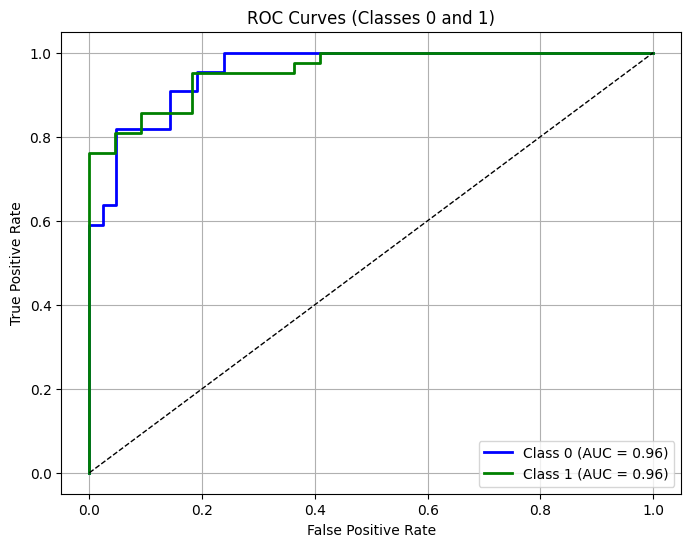

In [11]:
y_bin = label_binarize(test_y, classes=[0, 1])
if y_bin.shape[1] == 1:
    y_bin = np.hstack((1 - y_bin, y_bin))
fpr = {}
tpr = {}
roc_auc = {}

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['blue', 'green']
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Classes 0 and 1)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


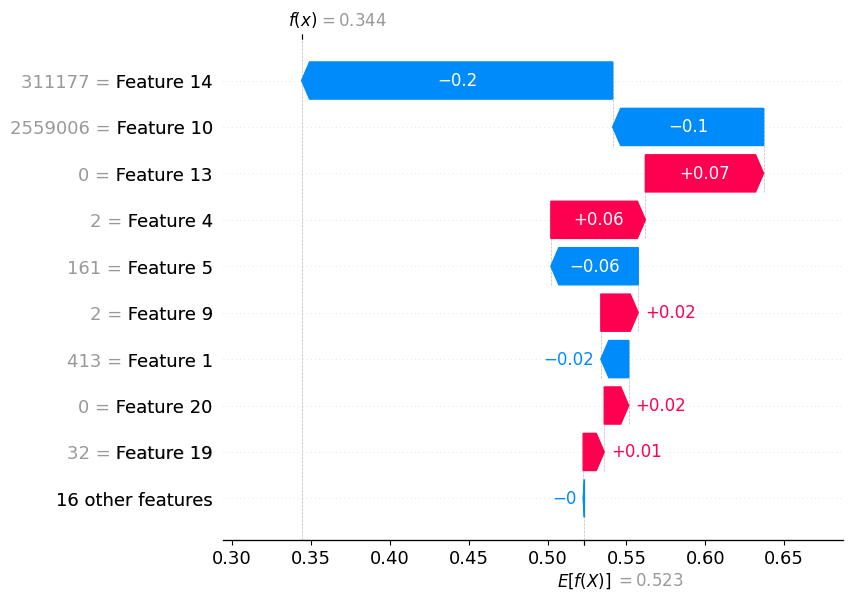

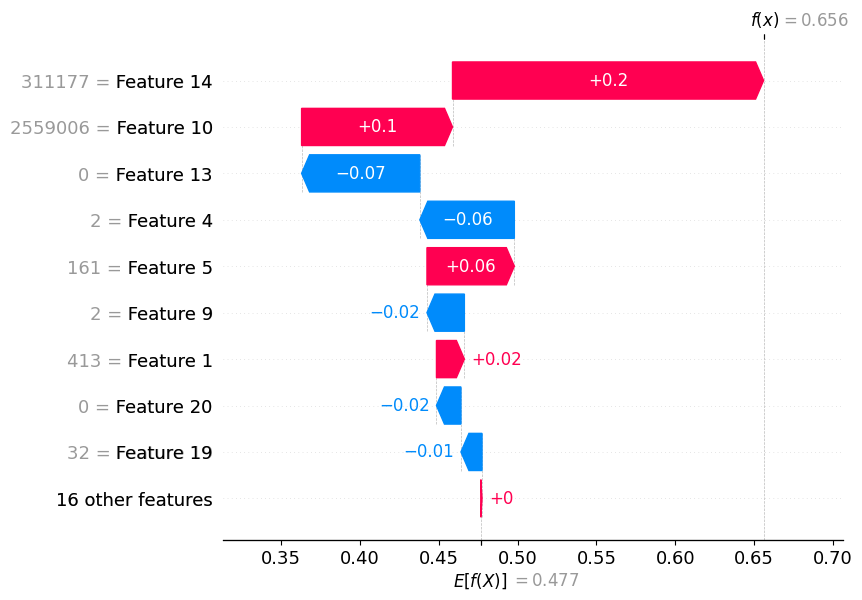

In [12]:
explainer = shap.Explainer(rf_model, X_resampled)

shap_values = explainer(test_x)

shap.plots.waterfall(shap.Explanation(
    values=shap_values.values[0][:, 1],
    base_values=shap_values.base_values[0][1],
    data=shap_values.data[0],
    feature_names=shap_values.feature_names
))

shap.plots.waterfall(shap.Explanation(
    values=shap_values.values[0][:, 0],
    base_values=shap_values.base_values[0][0],
    data=shap_values.data[0],
    feature_names=shap_values.feature_names
))

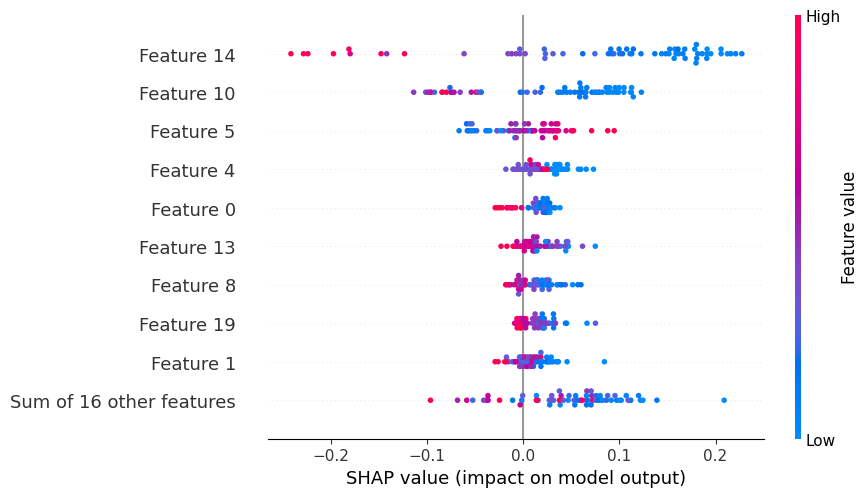

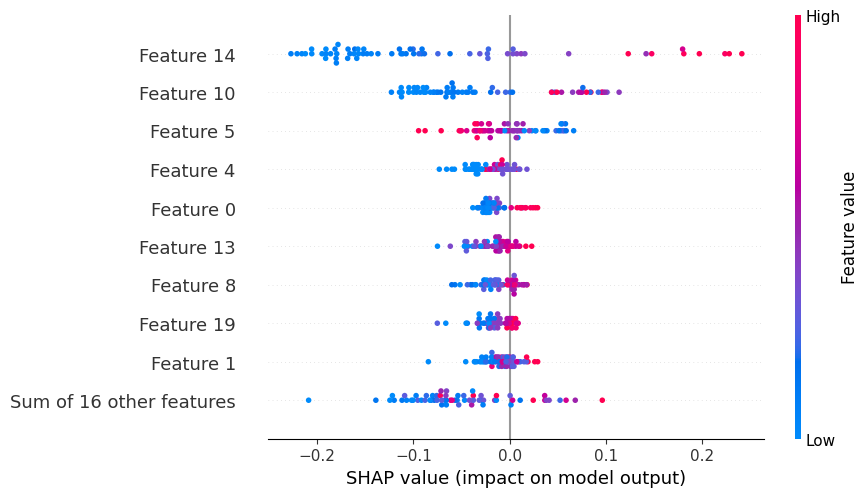

In [13]:
shap.plots.beeswarm(shap.Explanation(
    values=shap_values.values[:, :, 1],
    base_values=shap_values.base_values[:, 1],
    data=shap_values.data,
    feature_names=shap_values.feature_names
))

shap.plots.beeswarm(shap.Explanation(
    values=shap_values.values[:, :, 0],
    base_values=shap_values.base_values[:, 0],
    data=shap_values.data,
    feature_names=shap_values.feature_names
))


## XGBoost

In [14]:
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.005,
    subsample=0.9,
    colsample_bytree=0.8,
    eval_metric='logloss'
)

xgb_model.fit(X_resampled, y_resampled)

probs = xgb_model.predict_proba(test_x)
preds = xgb_model.predict(test_x)

print("Evaluation:")
print(f"Accuracy: {accuracy_score(test_y, preds):.4f}")
print(f"F1 Score (macro): {f1_score(test_y, preds, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(test_y, preds, average='weighted'):.4f}")

Evaluation:
Accuracy: 0.8281
F1 Score (macro): 0.7754
F1 Score (weighted): 0.8094


In [15]:
print("\nPer-Class Classification Report:")
print(classification_report(test_y, preds, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(test_y, preds))



Per-Class Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.5000    0.6667        22
           1     0.7925    1.0000    0.8842        42

    accuracy                         0.8281        64
   macro avg     0.8962    0.7500    0.7754        64
weighted avg     0.8638    0.8281    0.8094        64

Confusion Matrix:
[[11 11]
 [ 0 42]]


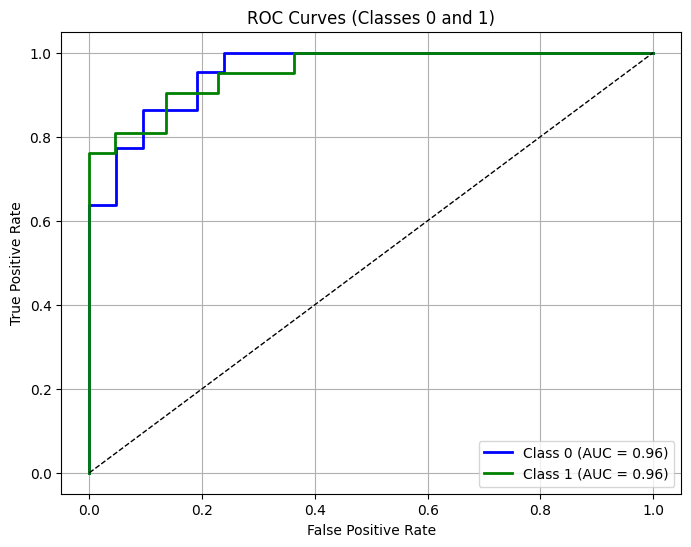

In [16]:
y_bin = label_binarize(test_y, classes=[0, 1])
if y_bin.shape[1] == 1:
    y_bin = np.hstack((1 - y_bin, y_bin))
fpr = {}
tpr = {}
roc_auc = {}

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['blue', 'green']
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Classes 0 and 1)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Waterfall plot for predicted class 0 (index 0):


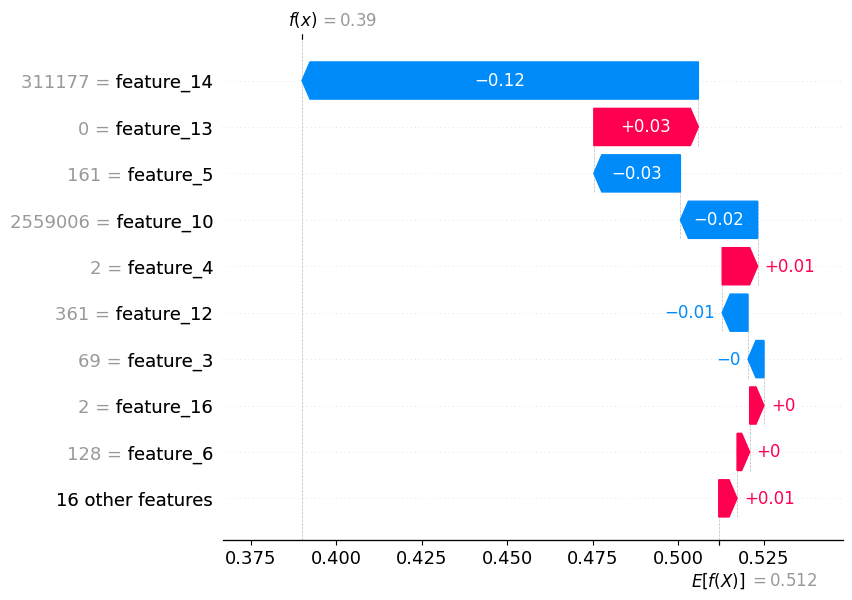

Waterfall plot for predicted class 1 (index 1):


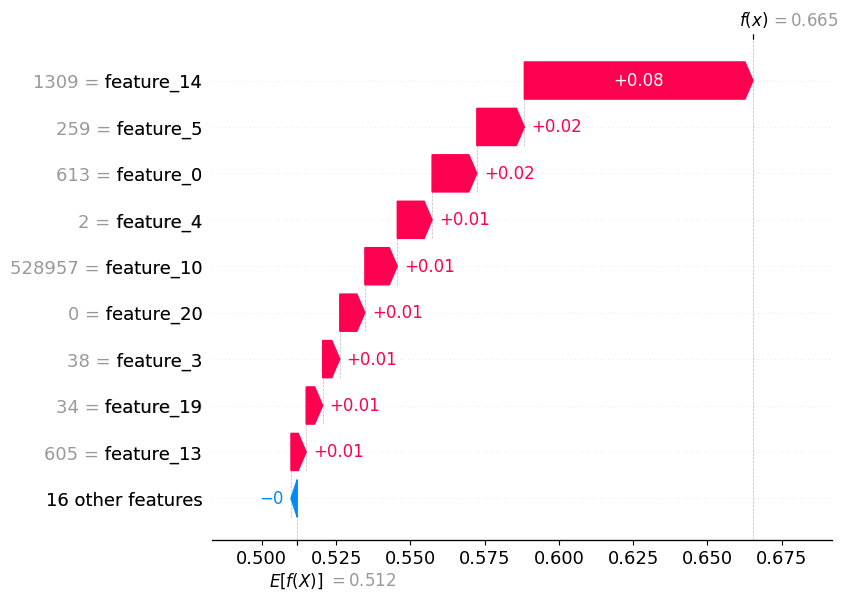

In [17]:
explainer = shap.TreeExplainer(xgb_model, X_resampled, feature_perturbation="interventional", model_output="probability")
shap_values = explainer.shap_values(test_x)

preds = xgb_model.predict(test_x)

idx_class_0 = np.where(preds == 0)[0][0]
idx_class_1 = np.where(preds == 1)[0][0]

feature_names = X_resampled.columns if hasattr(X_resampled, 'columns') else [f"feature_{i}" for i in range(test_x.shape[1])]

print(f"Waterfall plot for predicted class 0 (index {idx_class_0}):")
shap.plots.waterfall(shap.Explanation(
    values=shap_values[idx_class_0],
    base_values=explainer.expected_value,
    data=test_x[idx_class_0],
    feature_names=feature_names
))

print(f"Waterfall plot for predicted class 1 (index {idx_class_1}):")
shap.plots.waterfall(shap.Explanation(
    values=shap_values[idx_class_1],
    base_values=explainer.expected_value,
    data=test_x[idx_class_1],
    feature_names=feature_names
))


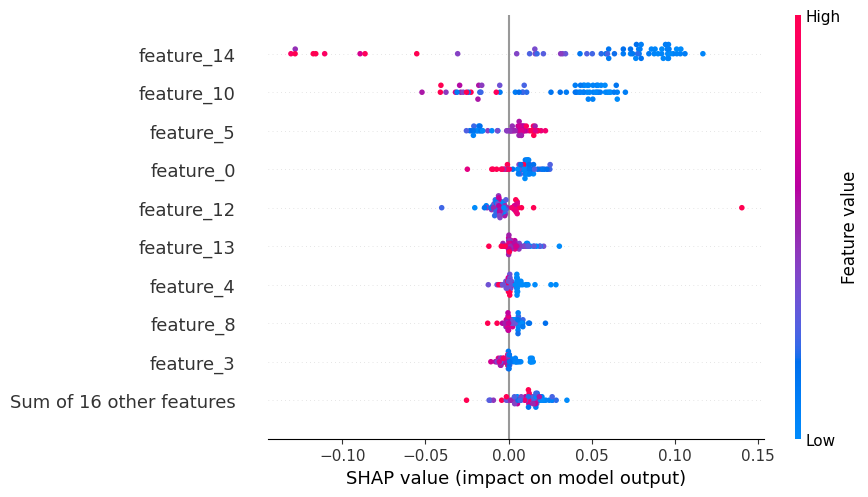

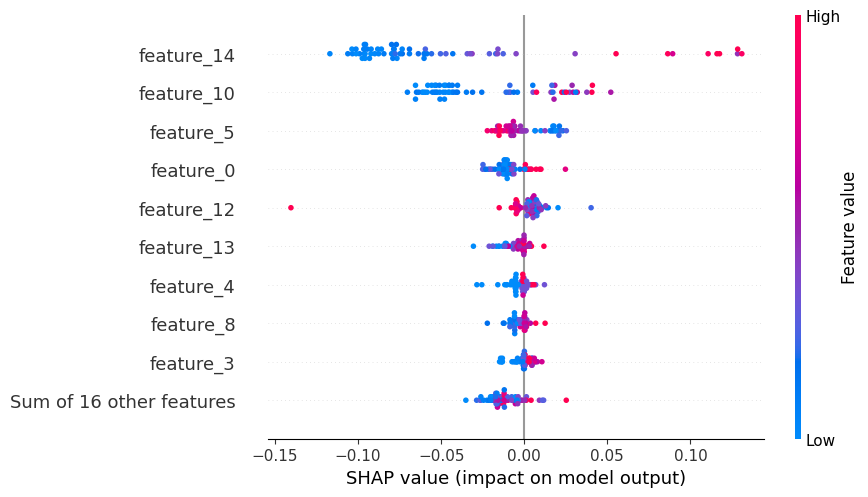

In [18]:
shap.plots.beeswarm(shap.Explanation(
    values=shap_values,
    base_values=np.repeat(explainer.expected_value, shap_values.shape[0]),
    data=test_x,
    feature_names=feature_names
))
shap_values_class_0 = -shap_values

shap.plots.beeswarm(shap.Explanation(
    values=shap_values_class_0,
    base_values=np.repeat(1 - explainer.expected_value, shap_values.shape[0]),
    data=test_x,
    feature_names=feature_names
))


In [19]:
# === Predict on full unlabeled set ===
unlabeled_probs = rf_model.predict_proba(unlabeled_x)
unlabeled_preds = rf_model.predict(unlabeled_x)
confidence_threshold = 0.95

final_unlabeled_preds = np.array([
    p if max(prob) >= confidence_threshold else 2
    for p, prob in zip(unlabeled_preds, unlabeled_probs)
])

# === Print stats ===
distribution = Counter(final_unlabeled_preds)
total = len(final_unlabeled_preds)
print("\nFinal Unlabeled Predictions Distribution:")
for label, count in distribution.items():
    pct = (count / total) * 100
    print(f"Class {label}: {count} ({pct:.2f}%)")



Final Unlabeled Predictions Distribution:
Class 2: 10467448 (79.65%)
Class 1: 2599954 (19.78%)
Class 0: 74219 (0.56%)


In [20]:
def postprocess_class1_sequences(unlabeled_x, unlabeled_y, unlabeled_meta, time_gap_threshold_us=5_000_000):
    feature_column_names = [
        'ClksThisMin', 'NofClx', 'medianKHz', 'avSPL', 'avPkAt',
        'AvPRF', 'avEndF', 'tWUTrisk', 'nActualClx', 'nRisingIPIs',
        'TrDur_us', 'nICIrising',
        'MinICI_us', 'midpointICI', 'MaxICI_us', 'ClkNofMinICI',
        'ClkNofMaxICI', 'NofClstrs',
        'avClstrNx8', 'avPkIPI', 'BeforeIPIratio', 'PreIPIratio',
        'Post1IPIratio', 'Post2IPIratio', 'EndIPIratio'
    ]
    trdur_idx =  feature_column_names.index('TrDur_us')

    data_by_location = defaultdict(list)
    for idx, meta in enumerate(unlabeled_meta):
        location, minute_str, micro_str = meta
        start_us = np.int64(int(minute_str)) * 60 * 1_000_000 + np.int64(int(micro_str))
        duration_us = np.int64(unlabeled_x[idx, trdur_idx])
        end_us = start_us + duration_us
        data_by_location[location].append((start_us, end_us, idx))
    for loc in data_by_location:
        data_by_location[loc].sort()
    new_labels = unlabeled_y.copy()

    for loc, entries in data_by_location.items():
        class1_entries = [(s, e, i) for (s, e, i) in entries if unlabeled_y[i] == 1]
        class1_entries.sort()

        current_sequence = []
        for j in range(len(class1_entries)):
            s, e, idx = class1_entries[j]
            if not current_sequence:
                current_sequence.append((s, e, idx))
            else:
                prev_s, prev_e, _ = current_sequence[-1]
                if s - prev_e <= time_gap_threshold_us:
                    current_sequence.append((s, e, idx))
                else:
                    if len(current_sequence) >= 2:
                        for _, _, seq_idx in current_sequence:
                            new_labels[seq_idx] = 1
                    else:
                        for _, _, seq_idx in current_sequence:
                            new_labels[seq_idx] = 2
                    current_sequence = [(s, e, idx)]

        if current_sequence:
            if len(current_sequence) >= 2:
                for _, _, seq_idx in current_sequence:
                    new_labels[seq_idx] = 1
            else:
                for _, _, seq_idx in current_sequence:
                    new_labels[seq_idx] = 2

    return new_labels

new_labels = postprocess_class1_sequences(unlabeled_x, final_unlabeled_preds, unlabeled_meta)

In [21]:
distribution = Counter(new_labels)
total = len(new_labels)
print("\nFinal Unlabeled Predictions Distribution:")
for label, count in distribution.items():
    pct = (count / total) * 100
    print(f"Class {label}: {count} ({pct:.2f}%)")


Final Unlabeled Predictions Distribution:
Class 2: 11585140 (88.16%)
Class 1: 1482262 (11.28%)
Class 0: 74219 (0.56%)


In [22]:
data = np.load("data/data/fixed_click_dataset.npz", allow_pickle=True)
labeled_sx = data['labeled_x']
labeled_sy = data['labeled_y']
signal_x = data['unlabeled_x']
signal_meta = data['unlabeled_meta']
labeled_smeta = data['labeled_meta']

In [23]:
special_areas = ['U Dzha Bay', 'U Dzha Sea']

signal_meta = np.array(signal_meta)
def extract_area_name(entry):
    entry_str = str(entry)
    for area in special_areas:
        if entry_str.startswith(area):
            return area
    match = re.match(r'^(\w+ \w+)', entry_str)
    return match.group(1) if match else entry_str

vectorized_extractor = np.vectorize(extract_area_name)

clean_unlabeled_meta = vectorized_extractor(signal_meta[:, 0])
meta_signal = np.column_stack((clean_unlabeled_meta, signal_meta[:, 1:3]))

In [ ]:
def save_labeled_visuals_by_location(
    labeled_x, labeled_y, labeled_meta,
    signal_x, signal_meta,
    location_filter='U Dzha Bay',
    save_dir='labeled_data_visuals',
    save_waveform_plot=True,
    max_per_class=30
):
    os.makedirs(save_dir, exist_ok=True)

    feature_column_names = [
        'ClksThisMin', 'NofClx', 'medianKHz', 'avSPL', 'avPkAt',
        'AvPRF', 'avEndF', 'tWUTrisk', 'nActualClx', 'nRisingIPIs',
        'TrDur_us', 'nICIrising',
        'MinICI_us', 'midpointICI', 'MaxICI_us', 'ClkNofMinICI',
        'ClkNofMaxICI', 'NofClstrs',
        'avClstrNx8', 'avPkIPI', 'BeforeIPIratio', 'PreIPIratio',
        'Post1IPIratio', 'Post2IPIratio', 'EndIPIratio'
    ]

    class_dirs = {
        0: os.path.join(save_dir, "class_0"),
        1: os.path.join(save_dir, "class_1"),
        2: os.path.join(save_dir, "noise")
    }
    for d in class_dirs.values():
        os.makedirs(d, exist_ok=True)

    filtered = [
        (x, y, meta) for x, y, meta in zip(labeled_x, labeled_y, labeled_meta)
        if meta[0] == location_filter
    ]

    if not filtered:
        print(f"No labeled instances found for location: {location_filter}")
        return

    signal_lookup = {tuple(m): s for s, m in zip(signal_x, signal_meta)}
    saved_counts = {0: 0, 1: 0, 2: 0}

    for i, (x, y, meta) in enumerate(tqdm(filtered)):
        identity = tuple([meta[0], int(meta[1]), int(meta[2])])
        raw_signal = signal_lookup.get(identity, None)

        if raw_signal is None:
            continue

        final_class = y if y in [0, 1] else 2
        if saved_counts[final_class] >= max_per_class:
            continue

        label_dir = class_dirs[final_class]
        base_name = f"{i}_{identity[0].replace(' ', '_')}_{identity[1]}_{identity[2]}"

        df_feat = pd.DataFrame([x], columns=feature_column_names)
        df_feat.to_csv(os.path.join(label_dir, f"{base_name}_features.csv"), index=False)

        if save_waveform_plot:
            plt.figure(figsize=(6, 3))
            plt.plot(raw_signal, lw=1)
            plt.title(f"Label: Class {final_class}")
            plt.xlabel("Time (sampled)")
            plt.ylabel("Clk/s")
            plt.tight_layout()
            plt.savefig(os.path.join(label_dir, f"{base_name}_waveform.png"))
            plt.close()

        saved_counts[final_class] += 1

        if all(saved_counts[c] >= max_per_class for c in saved_counts):
            print("Saved max limit for all classes. Stopping.")
            break

    print(f"Saved labeled data for location: {location_filter} to: {save_dir}")
    print(f"Saved counts: {saved_counts}")

save_labeled_visuals_by_location(
    unlabeled_x, final_unlabeled_preds, unlabeled_meta,
    signal_x, meta_signal,
    location_filter='U Kinburn',
    save_dir='data_files/Kinburn_data_visuals',
    save_waveform_plot=True,
    max_per_class=100
)